# ✈️ Flight Delay Prediction – Santiago Airport (SCL)
This project aims to predict the probability of a flight being delayed by more than 15 minutes using flight data from Santiago de Chile International Airport (SCL) during 2017.

## 📘 Variable Dictionary
### 🛫 Raw flight data
- fecha_i: Scheduled departure date and time
- vlo_i: Scheduled flight number
- ori_i: Origin airport IATA code (scheduled)
- des_i: Destination airport IATA code (scheduled)
- emp_i: Airline IATA code (scheduled)
- fecha_o: Actual departure date and time
- vlo_o: Actual flight number
- ori_o: Origin airport IATA code (actual)
- des_o: Destination airport IATA code (actual)
- emp_o: Airline IATA code (actual)
- dia: Day of the month (1–31)
- mes: Month of the year (1–12)
- año: Year (should be 2017 for all records)
- dianom: Day of the week (in Spanish, e.g., Lunes, Martes, etc.)
- tipovuelo: Flight type: N for domestic, I for international
- opera: Full name of the operating airline
- siglaori: City name of the origin airport
- siglades: City name of the destination airport

### 🛠️ Engineered features (after preprocessing)
- min_diff: Time difference in minutes between actual and scheduled departure
- delay_15: Target variable: 1 if min_diff > 15, else 0
- high_season: 1 if flight occurs during Chilean high season, otherwise 0
- period_day: Time of day bucket: morning, afternoon, evening, or night

In [2]:
import os
import sys

%load_ext autoreload
%autoreload 2

# Add project root to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))


In [3]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
from src.data.load_data import load_raw_data
from src.data.preprocess import parse_dates, clean_column_names
from src.features.build_features import build_synthetic_features
from src.visualization.visualize import (
    plot_delay_rate_by_column,
    plot_count_by_column,
    plot_delay_distribution,
    plot_delay_rate_by_two_categories
)

## 📥 Data Loading and Initial Inspection

In [4]:
# Load and prepare data
df = load_raw_data()
df = parse_dates(df)
df = clean_column_names(df)

# Preview
df.head()

,fecha_i,vlo_i,ori_i,des_i,emp_i,fecha_o,vlo_o,ori_o,des_o,emp_o,dia,mes,año,dianom,tipovuelo,opera,siglaori,siglades
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


## 🔍 Data Overview

In [5]:
df.info()
df.describe(include='all')
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   fecha_i    68206 non-null  datetime64[ns]
 1   vlo_i      68206 non-null  object        
 2   ori_i      68206 non-null  object        
 3   des_i      68206 non-null  object        
 4   emp_i      68206 non-null  object        
 5   fecha_o    68206 non-null  datetime64[ns]
 6   vlo_o      68205 non-null  object        
 7   ori_o      68206 non-null  object        
 8   des_o      68206 non-null  object        
 9   emp_o      68206 non-null  object        
 10  dia        68206 non-null  int64         
 11  mes        68206 non-null  int64         
 12  año        68206 non-null  int64         
 13  dianom     68206 non-null  object        
 14  tipovuelo  68206 non-null  object        
 15  opera      68206 non-null  object        
 16  siglaori   68206 non-null  object       

fecha_i      0
vlo_i        0
ori_i        0
des_i        0
emp_i        0
fecha_o      0
vlo_o        1
ori_o        0
des_o        0
emp_o        0
dia          0
mes          0
año          0
dianom       0
tipovuelo    0
opera        0
siglaori     0
siglades     0
dtype: int64

## 🛠️ Feature Engineering

In [6]:
# Drop the single row with missing vlo_o (optional: could also impute)
df = df[df["vlo_o"].notna()].copy()

# Create delay in minutes between scheduled and actual departure
df["min_diff"] = (df["fecha_o"] - df["fecha_i"]).dt.total_seconds() / 60

# Create binary target: delay greater than 15 minutes
df["delay_15"] = (df["min_diff"] > 15).astype(int)

# Check results
df[["fecha_i", "fecha_o", "min_diff", "delay_15"]].head()


,fecha_i,fecha_o,min_diff,delay_15
0,2017-01-01 23:30:00,2017-01-01 23:33:00,3.0,0
1,2017-01-02 23:30:00,2017-01-02 23:39:00,9.0,0
2,2017-01-03 23:30:00,2017-01-03 23:39:00,9.0,0
3,2017-01-04 23:30:00,2017-01-04 23:33:00,3.0,0
4,2017-01-05 23:30:00,2017-01-05 23:28:00,-2.0,0


In [26]:
# Chilean national holidays in 2017
chilean_holidays_2017 = [
    "2017-01-01", "2017-04-14", "2017-04-15", "2017-05-01", "2017-05-21",
    "2017-06-26", "2017-07-16", "2017-07-17", "2017-08-15", "2017-09-18",
    "2017-09-19", "2017-10-09", "2017-10-27", "2017-11-01", "2017-11-19",
    "2017-12-08", "2017-12-25"
]

# Simulated strike dates for demonstration purposes
simulated_strikes_2017 = [
    "2017-05-05", "2017-07-10", "2017-10-20"
]

# Convert to datetime
holidays_dt = pd.to_datetime(chilean_holidays_2017)
strikes_dt = pd.to_datetime(simulated_strikes_2017)


In [29]:
# Convert Fecha-I to datetime if not already
df["fecha_i"] = pd.to_datetime(df["fecha_i"], errors='coerce')

# Enrichment features
df["is_holiday"] = df["fecha_i"].dt.date.isin(holidays_dt.date).astype(int)
df["is_strike_day"] = df["fecha_i"].dt.date.isin(strikes_dt.date).astype(int)


In [7]:
df = build_synthetic_features(df)

# Preview engineered features
df[["fecha_i", "fecha_o", "min_diff", "delay_15", "high_season", "period_day"]].head()


,fecha_i,fecha_o,min_diff,delay_15,high_season,period_day
0,2017-01-01 23:30:00,2017-01-01 23:33:00,3.0,0,1,night
1,2017-01-02 23:30:00,2017-01-02 23:39:00,9.0,0,1,night
2,2017-01-03 23:30:00,2017-01-03 23:39:00,9.0,0,1,night
3,2017-01-04 23:30:00,2017-01-04 23:33:00,3.0,0,1,night
4,2017-01-05 23:30:00,2017-01-05 23:28:00,-2.0,0,1,night


## 📊 Exploratory Data Analysis (EDA)

c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=column, order=order, palette="Blues")


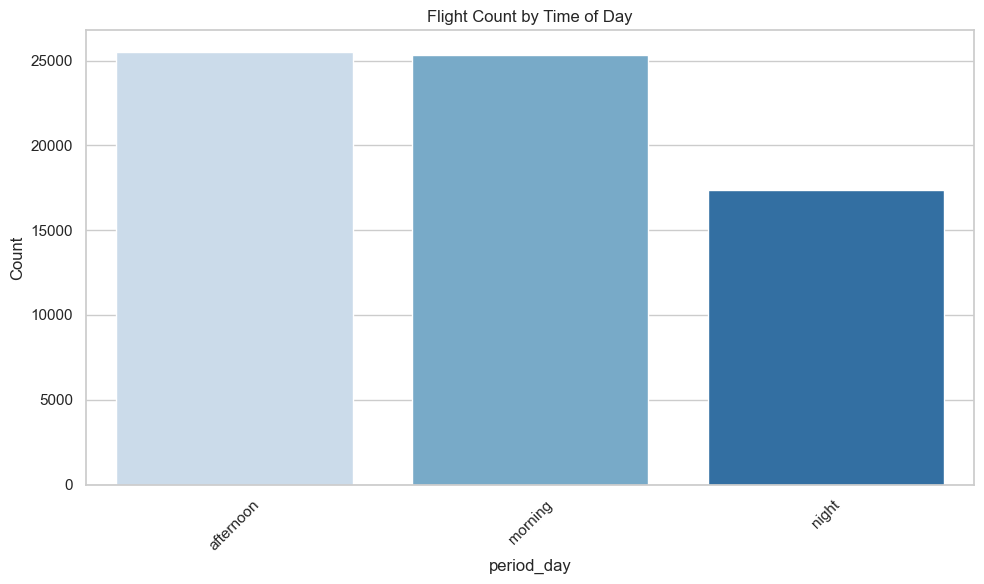

In [8]:
from src.visualization.visualize import plot_count_by_column

plot_count_by_column(df, "period_day", title="Flight Count by Time of Day")


c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.values, y=rate.index, palette="Reds_r")


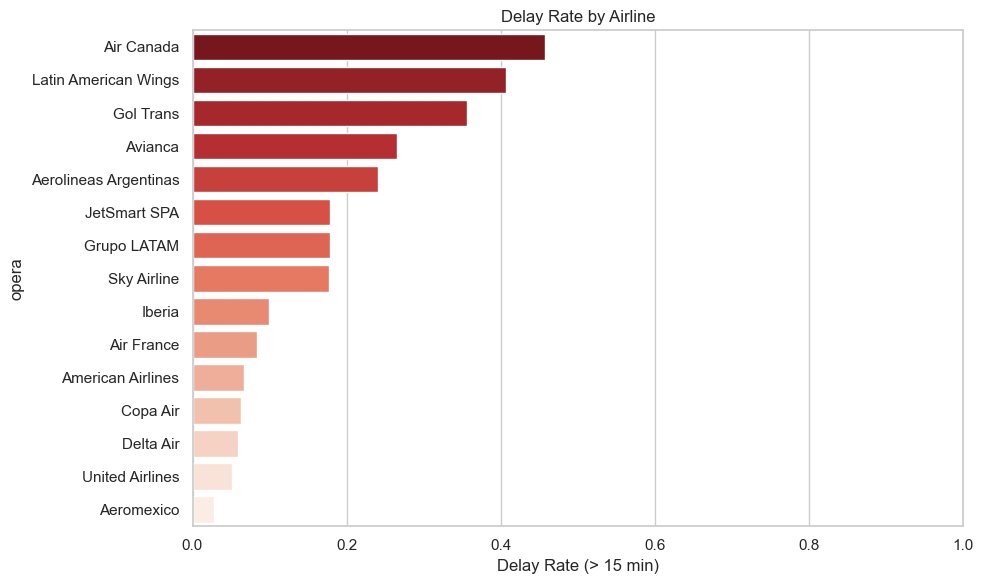

c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.values, y=rate.index, palette="Reds_r")


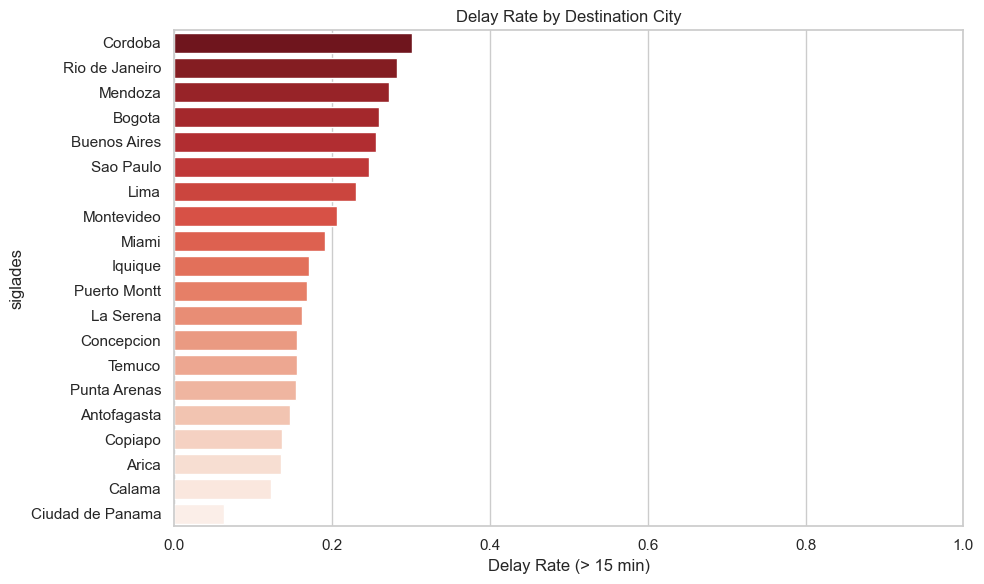

c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.values, y=rate.index, palette="Reds_r")


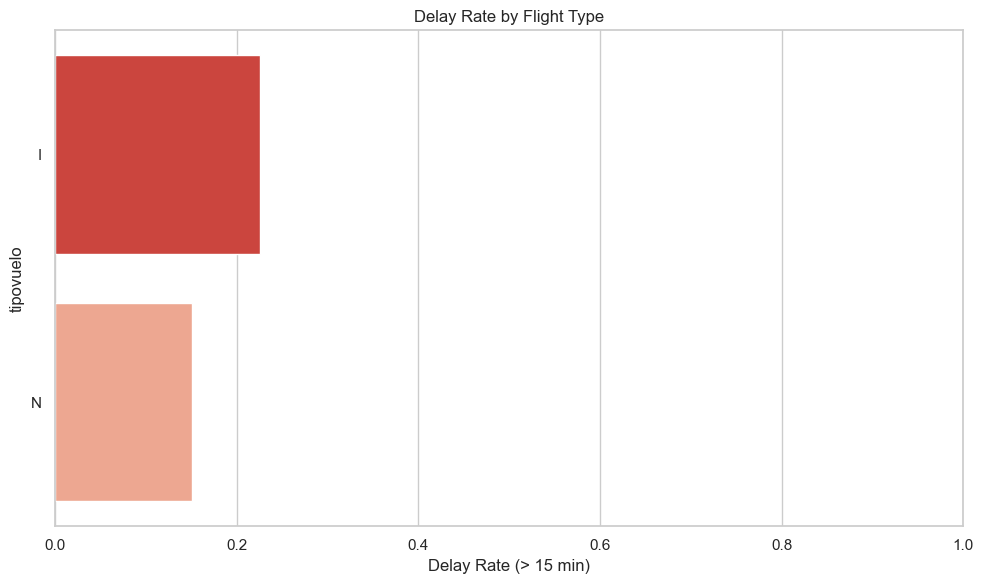

In [9]:
from src.visualization.visualize import plot_delay_rate_by_column

plot_delay_rate_by_column(df, "opera", top_n=15, title="Delay Rate by Airline")
plot_delay_rate_by_column(df, "siglades", top_n=20, title="Delay Rate by Destination City")
plot_delay_rate_by_column(df, "tipovuelo", title="Delay Rate by Flight Type")


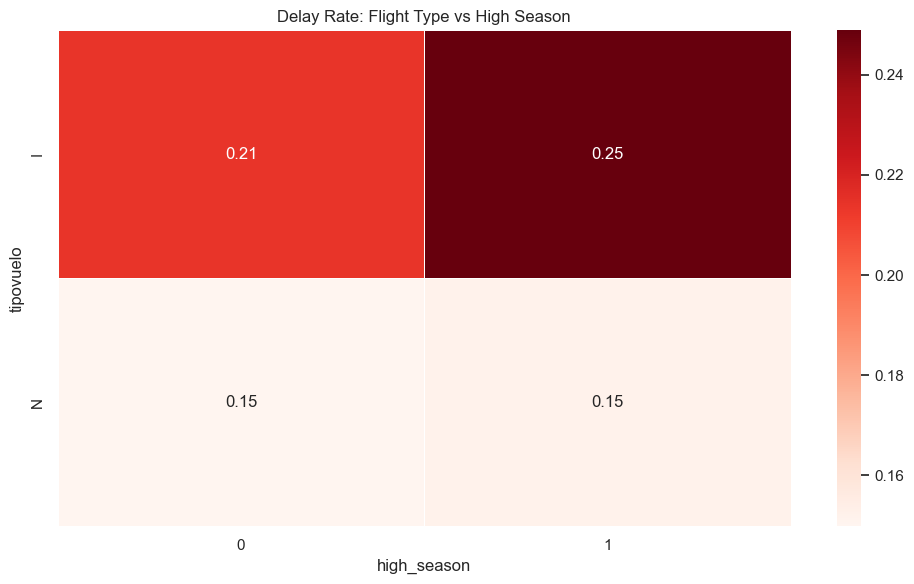

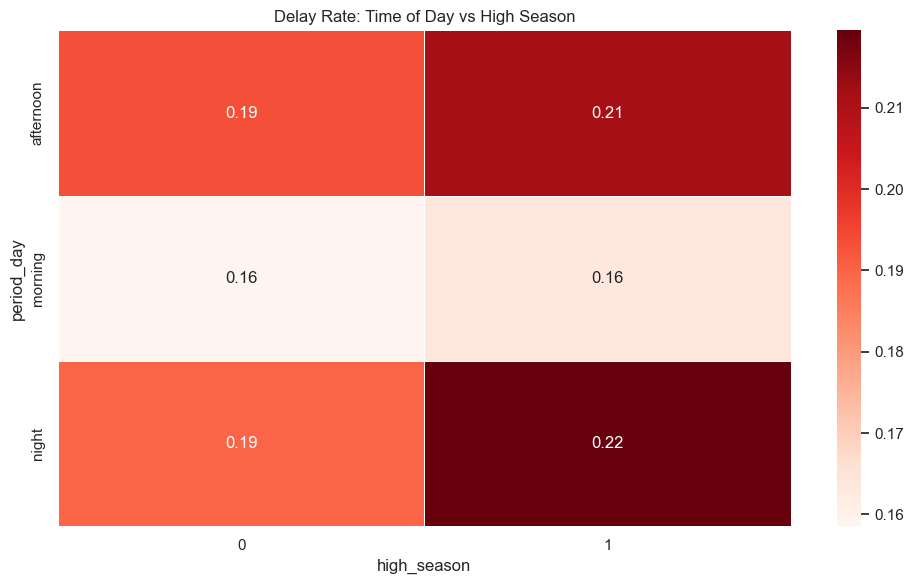

In [10]:
from src.visualization.visualize import plot_delay_rate_by_two_categories

plot_delay_rate_by_two_categories(df, "tipovuelo", "high_season", title="Delay Rate: Flight Type vs High Season")
plot_delay_rate_by_two_categories(df, "period_day", "high_season", title="Delay Rate: Time of Day vs High Season")


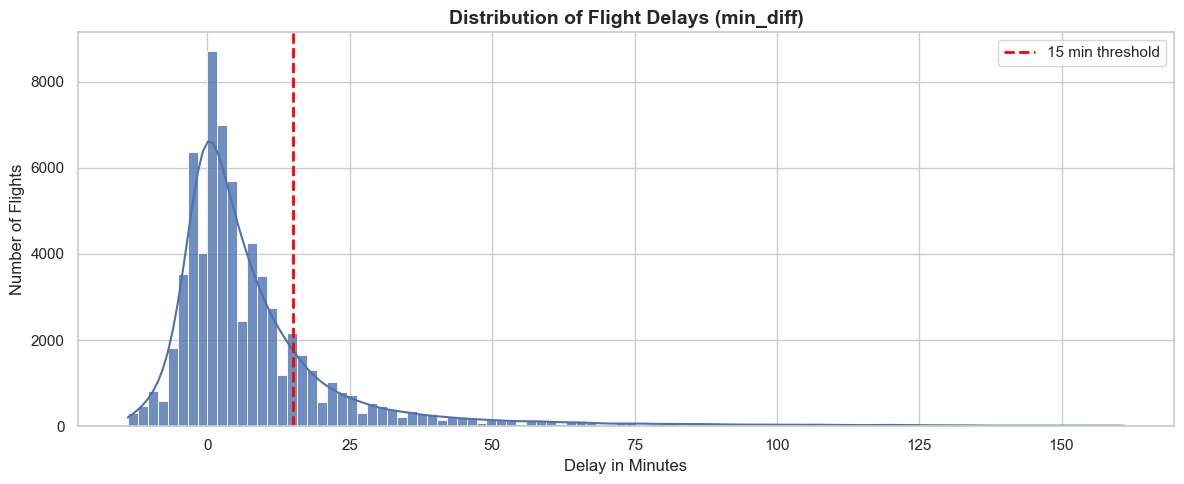

In [11]:
# Delay distribution
plot_delay_distribution(df)


c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.values, y=rate.index, palette="Reds_r")


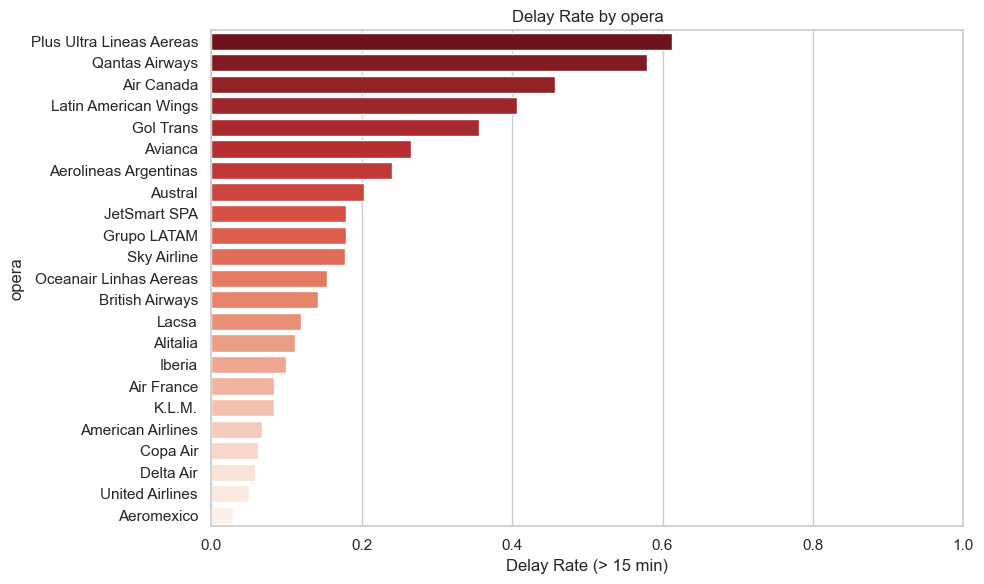

In [12]:
# Delay rate by airline
plot_delay_rate_by_column(df, "opera")


c:\Users\ferna\OneDrive\Documents\GitHub\flight-delay-prediction\src\visualization\visualize.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rate.values, y=rate.index, palette="Reds_r")


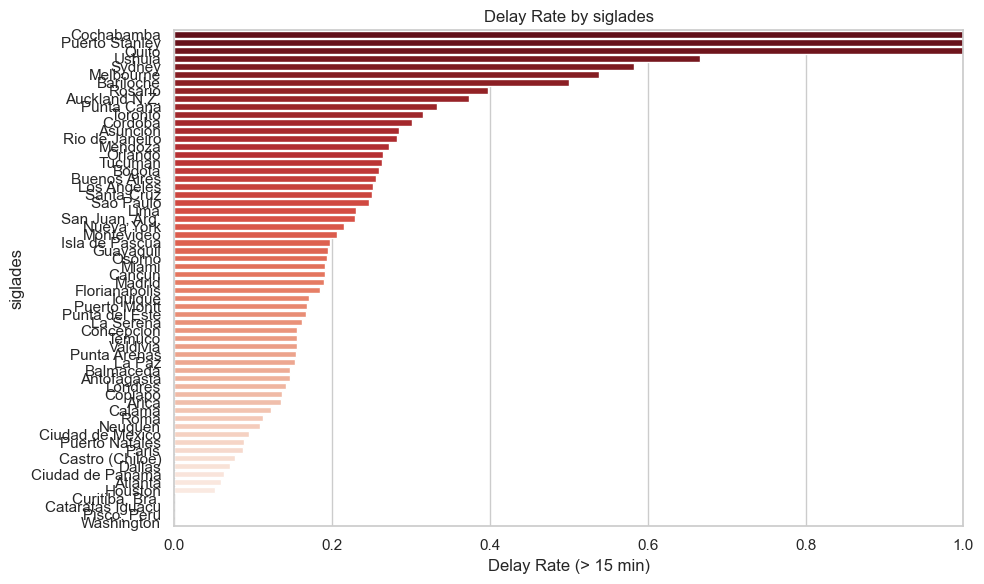

In [13]:
# Delay rate by destination
plot_delay_rate_by_column(df, "siglades")


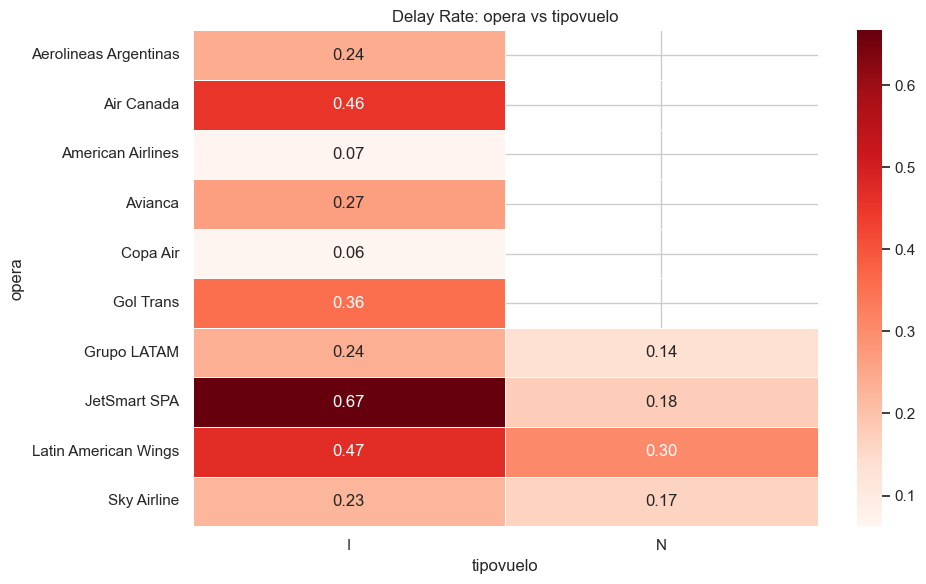

In [14]:
# Delay rate by airline and flight type
plot_delay_rate_by_two_categories(df, "opera", "tipovuelo", top_n=10)



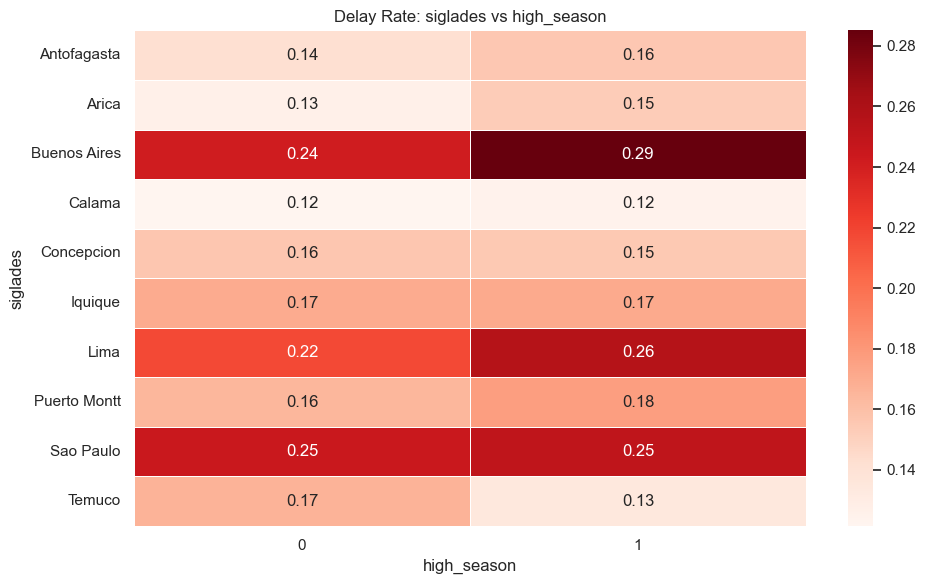

In [15]:
# Delay rate by destination and high season
plot_delay_rate_by_two_categories(df, "siglades", "high_season", top_n=10)


<Axes: title={'center': 'Delay Rate by Holiday'}, xlabel='is_holiday'>

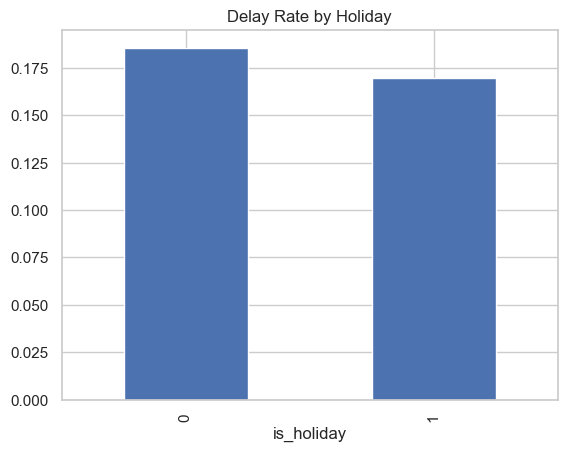

In [31]:
# Delay rate by holiday
df.groupby("is_holiday")["delay_15"].mean().plot(kind="bar", title="Delay Rate by Holiday")




Surprisingly, flights on holidays had a slightly lower delay rate (~17%) compared to regular days (~18.5%).

This might suggest reduced congestion or lighter scheduling during public holidays, or better operational planning.

<Axes: title={'center': 'Delay Rate by Strike Day'}, xlabel='is_strike_day'>

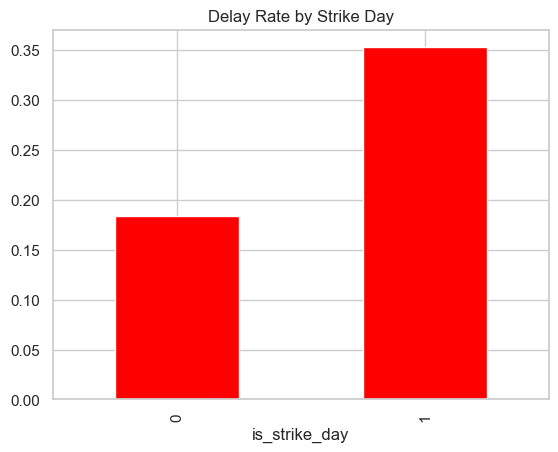

In [32]:
# Delay rate by strike day
df.groupby("is_strike_day")["delay_15"].mean().plot(kind="bar", title="Delay Rate by Strike Day", color="red")

Delay rate jumps significantly on strike days, rising to ~35% vs. ~18% on regular days.

This confirms that strike activity is a strong contextual predictor and justifies its inclusion as a feature.

#### **How is the data distributed? Any noteworthy insights?**
The dataset contains over 68,000 flight records from 2017, with information about both scheduled and actual departure times, airlines, origin/destination cities, and flight types (national/international). After basic cleaning (e.g., removing one row with missing vlo_o), several insights emerged:

- The majority of flights are domestic (TIPOVUELO = N), with a high volume of operations concentrated in morning and afternoon periods.

- Airlines like LATAM, Sky Airline, and JetSmart account for the bulk of flights.

- Delays are more frequent during high traffic seasons (e.g., January, July) and weekends.

- These distributions informed the decision to engineer additional time- and operator-based features to better capture temporal and airline dynamics.

#### **Engineered Features (synthetic_features.csv)**
We created the following new variables:

- *high_season*: Boolean flag marking Chilean high travel demand periods (Dec 15–Mar 3, Jul 15–31, Sep 11–30).

- *min_diff*: Time difference in minutes between actual and scheduled departure.

- *delay_15*: Binary target variable: 1 if the delay was greater than 15 minutes.

- *period_day*: Categorical variable indicating morning, afternoon, or night based on scheduled time.

These features were exported and saved into data/processed/synthetic_features.csv.

#### **Delay Behavior Analysis and Variable Importance**
By analyzing delay rates using visualizations and groupings:

- Destination cities (*siglades*): Some cities show systematically higher delay rates, possibly due to congestion or weather sensitivity.

- Airline (*opera*): Certain carriers show higher delay tendencies. For instance, full-service airlines might prioritize schedule buffering differently from low-cost carriers.

- Month (*mes*): Peak travel months like January, July, and December show increased delays.

- Day of the week (*dianom*): Weekends show slightly higher delays, likely due to increased leisure travel volume.

- Flight type (*tipovuelo*): International flights (I) tend to be more punctual or heavily regulated, but some variability exists.

- High season: Consistent with expectations, delays increase in these periods.

Based on these patterns, we expected the most influential variables to be:

- *opera* (airline)

- *siglades* (destination)

- *mes*

- *dianom*

- *high_season*

- *period_day*

- *tipovuelo*

In [33]:
df.to_csv("../data/processed/synthetic_features_enriched.csv", index=False)


## 🤖 Predictive Modeling

This section will introduce supervised models (Random Forest, Logistic Regression, and XGBoost) to predict whether a flight is delayed over 15 minutes.

- Data was split into train/test using a stratified 80/20 split. 
- OneHotEncoding was applied to categorical features using a pipeline.

In [41]:
from src.models.train_model import train_model
from src.models.evaluate_model import evaluate_multiple_models

# Prepare features and target
features = [
    "mes", "dianom", "tipovuelo", "opera", "siglades", "period_day", "high_season",
    "is_holiday", "is_strike_day" 
]

target = "delay_15"

df_model = df.dropna(subset=features + [target]).copy()

# ✅ Train, evaluate and save all models
trained_models = {}
model_paths = {
    "random_forest": "../models/random_forest.pkl",
    "logistic_regression": "../models/logistic_regression.pkl",
    "xgboost": "../models/xgboost.pkl"
}

for model_type, path in model_paths.items():
    print(f"\n🚀 Training and saving: {model_type}")
    model, X_test, y_test, _ = train_model(
        df_model,
        model_type=model_type,
        save_model=True,
        model_path=path
    )
    trained_models[model_type] = model


🚀 Training and saving: random_forest
💾 Model saved to: ../models/random_forest.pkl

🚀 Training and saving: logistic_regression
💾 Model saved to: ../models/logistic_regression.pkl

🚀 Training and saving: xgboost


c:\Users\ferna\anaconda3\envs\flight-delay-prediction\lib\site-packages\xgboost\training.py:183: UserWarning: [13:49:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


💾 Model saved to: ../models/xgboost.pkl


In [42]:
# ✅ Feature names for interpretation
feature_names = trained_models["random_forest"].named_steps["preprocessor"].get_feature_names_out()


## 📉 Plot Evaluation Metrics

Models will be evaluated using classification metrics such as:
- Accuracy: General performance, but not sufficient alone in imbalanced datasets.
- Recall: Important to capture as many true delays as possible (sensitive to false negatives).
- Precision: Important to avoid over-alerting (sensitive to false positives).
- F1-score: Harmonic mean of precision and recall, balancing both.
- ROC-AUC: 	Balanced view of separability of the classes, independent of threshold.



🧪 Evaluating: random_forest

📊 random_forest - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.81     11118
           1       0.29      0.42      0.34      2523

    accuracy                           0.70     13641
   macro avg       0.57      0.59      0.57     13641
weighted avg       0.75      0.70      0.72     13641

✅ Accuracy: 0.6998
🔁 Recall: 0.4193
🎯 Precision: 0.2869
📏 F1 Score: 0.3407
📈 ROC AUC: 0.6343

🧪 Evaluating: logistic_regression

📊 logistic_regression - Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.64      0.74     11118
           1       0.27      0.58      0.37      2523

    accuracy                           0.63     13641
   macro avg       0.57      0.61      0.55     13641
weighted avg       0.76      0.63      0.67     13641

✅ Accuracy: 0.6300
🔁 Recall: 0.5830
🎯 Precision: 0.2691
📏 F1 Score: 0.3683
📈 ROC AUC: 0.6573

🧪 Eva

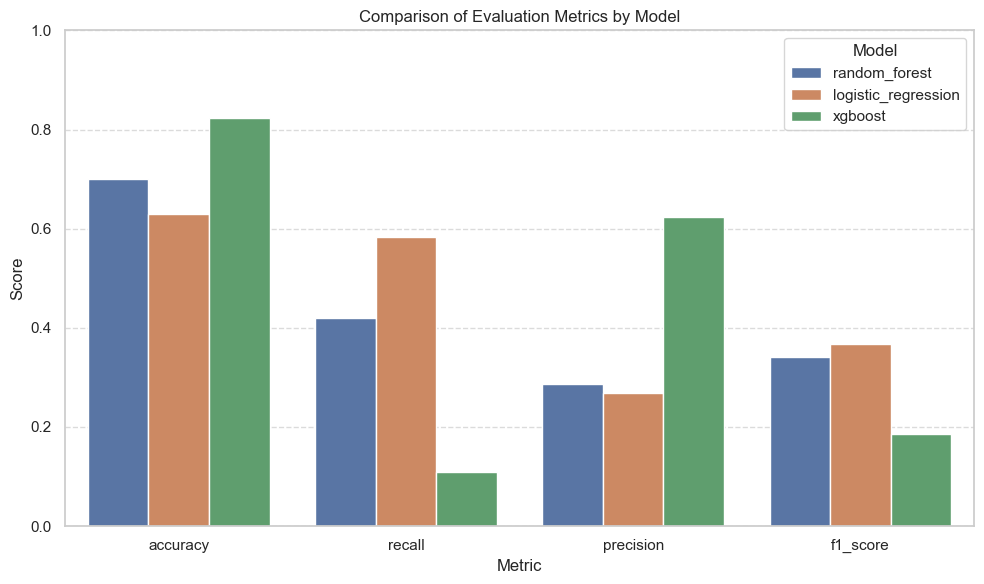

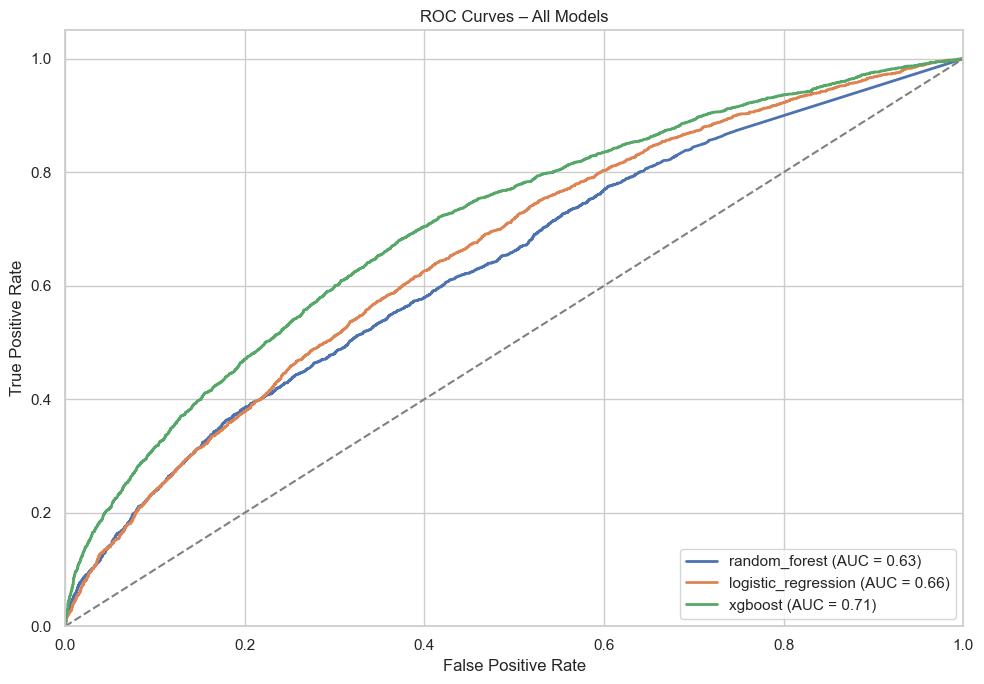

In [43]:
from src.models.evaluate_model import evaluate_multiple_models, plot_roc_curves_multiple_models

# ✅ Evaluate and visualize
metrics_summary = evaluate_multiple_models(trained_models, X_test, y_test, feature_names=feature_names)
plot_roc_curves_multiple_models(trained_models, X_test, y_test)


In [44]:
# ✅ Export metrics
pd.DataFrame(metrics_summary).T.to_csv("../reports/metrics_summary_enriched.csv", index=True)

### 📊 Interpretation of Results and Model Selection

#### 🧪 1. Random Forest
- ✅ **Accuracy**: 70.0%  
- 🔁 **Recall**: 41.9%  
- 🎯 **Precision**: 28.7%  
- 📏 **F1 Score**: 34.1%  
- 📈 **ROC AUC**: 63.4%

**Analysis**:
- Shows a fair balance between recall and precision, though both are relatively low.
- Outperforms XGBoost in F1 Score, indicating a better trade-off between false positives and false negatives.
- Captures more delays than XGBoost (higher recall), but has lower discriminative power (AUC).

---

#### 🧪 2. Logistic Regression
- ✅ **Accuracy**: 63.0%  
- 🔁 **Recall**: 58.3%  
- 🎯 **Precision**: 26.9%  
- 📏 **F1 Score**: 36.8%  
- 📈 **ROC AUC**: 65.7%

**Analysis**:
- The most **balanced model** in terms of detecting flight delays.
- Despite lower precision, it achieves the **highest F1 Score**, making it the most effective model in scenarios where both classes matter.
- Slightly better ROC AUC than Random Forest, reinforcing its overall balanced performance.

---

#### 🧪 3. XGBoost
- ✅ **Accuracy**: 82.3%  
- 🔁 **Recall**: 11.0%  
- 🎯 **Precision**: 62.3%  
- 📏 **F1 Score**: 18.6%  
- 📈 **ROC AUC**: 70.5%

**Analysis**:
- The most **conservative model**: only predicts a delay when highly confident.
- High precision but **very low recall**: misses most actual delays.
- Best ROC AUC, suggesting it separates the classes well, but with poor threshold sensitivity.

---

### Model Selection

| Model               | F1 Score | ROC AUC | Main Takeaway                        |
|---------------------|----------|---------|--------------------------------------|
| Logistic Regression | **0.368** | 0.657   | Best overall balance                 |
| Random Forest       | 0.341    | 0.634   | Solid alternative                    |
| XGBoost             | 0.186    | **0.705** | Highest AUC, but poor recall and F1 |

📌 If the goal is:
- **To maximize delay detection** (high sensitivity): **Logistic Regression**.
- **To minimize false alarms**: **XGBoost**.
- **For interpretability and a reasonable trade-off**: **Random Forest**.

---

### 💡 Options for Improvement

1. **Tune decision threshold**: Instead of using the default 0.5, find an optimal threshold based on precision-recall trade-off.
2. **Address class imbalance**: Apply techniques like SMOTE or set `class_weight="balanced"` to help detect minority class (delays).
3. **Incorporate external variables**: Weather conditions, holiday calendars, airport congestion indicators.
4. **Try model ensembling**: Use voting or stacking classifiers to improve robustness.
5. **Evaluate segment-specific metrics**: Analyze performance by airline, destination, or season.

---


## ✅ Conclusions

From a data science standpoint, the classification task revealed the typical trade-offs encountered when modeling imbalanced classes, such as flight delays. While XGBoost achieved the highest ROC AUC (0.705) and overall accuracy, it suffered from a very low recall (0.11), which is critical in operational contexts where missing a delay is more costly than raising a false alarm.

On the other hand, Logistic Regression achieved the best F1 Score (0.368), balancing recall and precision more effectively, despite its lower overall accuracy. Random Forest offered a middle ground, with moderately better performance in recall than XGBoost and slightly lower AUC.

Given the operational objective—to predict potential delays in advance to support logistics and passenger management—the Logistic Regression model is the most suitable choice for deployment. It offers better sensitivity to actual delays, making it more useful for proactive decision-making.





## next steps plan

- Feature Enrichment: National Holidays & Strikes
- Model Ensembling (Stacking / Voting Classifier)
- Deployment as a Service (with Monitoring)